In [ ]:
import pandas as pd
import json
from tqdm import tqdm
import os

In [3]:


def process_jsonl_in_chunks(file_path, chunk_size=10000):
    """Process large JSONL file in chunks"""
    # Verify file exists
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
        
    chunks = []
    records = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            # Count total lines for progress bar
            total_lines = sum(1 for _ in open(file_path, 'r'))
            f.seek(0)  # Reset file pointer
            
            for line in tqdm(f, total=total_lines, desc="Processing"):
                record = json.loads(line.strip())
                session_id = record['session']
                for event in record['events']:
                    records.append({
                        'session': session_id,
                        'aid': event['aid'],
                        'ts': event['ts'],
                        'type': event['type']
                    })
                
                if len(records) >= chunk_size:
                    chunks.append(pd.DataFrame(records))
                    records = []
    
        # Add remaining records
        if records:
            chunks.append(pd.DataFrame(records))
        
        return pd.concat(chunks, ignore_index=True)
    except Exception as e:
        print(f"Error processing file {file_path}: {str(e)}")
        raise

# Create data directories if they don't exist
os.makedirs('data/processed', exist_ok=True)

# Process files with correct paths
train_path = 'D:/voiceflip/datasets/otto-recsys-train.jsonl'
test_path = 'D:/voiceflip/datasets/otto-recsys-test.jsonl'

# Verify files exist before processing
if not os.path.exists(train_path):
    raise FileNotFoundError(f"Training file not found at: {train_path}")
if not os.path.exists(test_path):
    raise FileNotFoundError(f"Test file not found at: {test_path}")

# Process files
print("Processing train data...")
train_df = process_jsonl_in_chunks(train_path)
print("\nProcessing test data...")
test_df = process_jsonl_in_chunks(test_path)
# Add source column
train_df['source'] = 'train'
test_df['source'] = 'test'


# Display basic statistics
print("\n=== Dataset Overview ===")
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print("\nEvent type distribution in train:")
print(train_df['type'].value_counts(normalize=True))

Processing train data...


Processing: 100%|██████████| 12899779/12899779 [10:43<00:00, 20047.27it/s]



Processing test data...


Processing: 100%|██████████| 1671803/1671803 [00:31<00:00, 52968.77it/s]



=== Dataset Overview ===
Train shape: (216716096, 5)
Test shape: (13851293, 5)

Event type distribution in train:
type
clicks    0.898507
carts     0.077965
orders    0.023528
Name: proportion, dtype: float64


In [4]:
train_df.head()

,session,aid,ts,type,source
0,0,1517085,1659304800025,clicks,train
1,0,1563459,1659304904511,clicks,train
2,0,1309446,1659367439426,clicks,train
3,0,16246,1659367719997,clicks,train
4,0,1781822,1659367871344,clicks,train


In [5]:
test_df.head()

,session,aid,ts,type,source
0,12899779,59625,1661724000278,clicks,test
1,12899779,875854,1661724026702,clicks,test
2,12899780,1142000,1661724000378,clicks,test
3,12899780,582732,1661724058352,clicks,test
4,12899780,973453,1661724109199,clicks,test


In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216716096 entries, 0 to 216716095
Data columns (total 5 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   session  int64 
 1   aid      int64 
 2   ts       int64 
 3   type     object
 4   source   object
dtypes: int64(3), object(2)
memory usage: 8.1+ GB


In [6]:
train_df.isna().sum()   

session    0
aid        0
ts         0
type       0
source     0
dtype: int64

In [16]:
test_df.isna().sum()

session    0
aid        0
ts         0
type       0
source     0
dtype: int64

In [17]:
train_df.duplicated().sum()

np.int64(331159)

In [25]:
train_df = train_df.drop_duplicates()

In [19]:
test_df.duplicated().sum()

np.int64(18895)

In [26]:
test_df = test_df.drop_duplicates()

In [24]:
duplicados_df = test_df[test_df.duplicated(keep=False)].sort_values(by=list(test_df.columns)).head()
duplicados_df


,session,aid,ts,type,source
464,12899799,413826,1661808401955,orders,test
467,12899799,413826,1661808401955,orders,test
458,12899799,1191715,1661808401955,orders,test
460,12899799,1191715,1661808401955,orders,test
462,12899799,1309722,1661808401955,orders,test


## Analisis de columnas clave
1. Distribución de Eventos(type)

type
clicks    0.899439
carts     0.078046
orders    0.022515
Name: proportion, dtype: float64


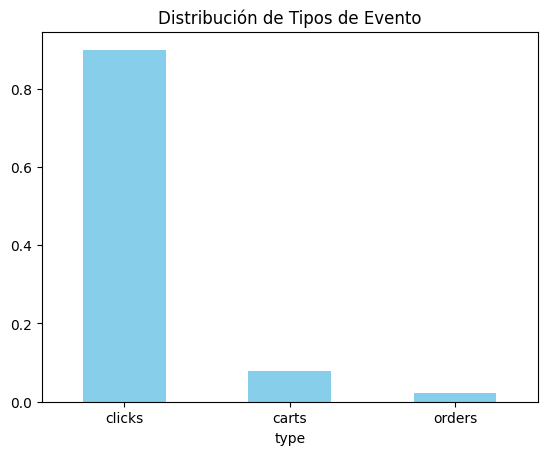

In [27]:
import matplotlib.pyplot as plt

# Conteo y proporción
event_dist = train_df['type'].value_counts(normalize=True)
print(event_dist)

# Gráfico
event_dist.plot(kind='bar', color='skyblue')
plt.title('Distribución de Tipos de Evento')
plt.xticks(rotation=0)
plt.show()

2. Articulos Más Interactuados(aid)


Top 10 Artículos Más Interactuados:
       aid  Interacciones
0  1460571         128939
1   485256         126745
2   108125         118470
3    29735         113220
4  1733943         105028
5   832192          91294
6   184976          90201
7   166037          84620
8   554660          80162
9   231487          79459


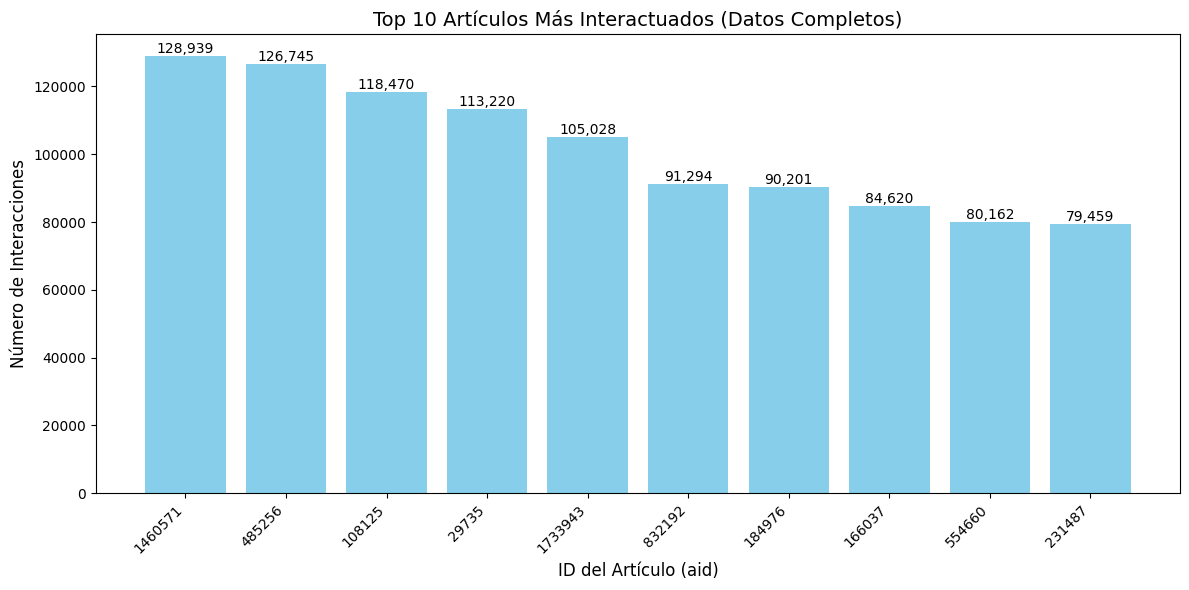

In [29]:
# 1. Análisis con todos los datos
top_10_articles = train_df['aid'].value_counts().head(10).reset_index()
top_10_articles.columns = ['aid', 'Interacciones']  # Renombrar la columna

print('\nTop 10 Artículos Más Interactuados:')
print(top_10_articles)

# 2. Gráfico con todos los datos
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_articles['aid'].astype(str), top_10_articles['Interacciones'], color='skyblue')

# Añadir etiquetas y título
plt.title('Top 10 Artículos Más Interactuados (Datos Completos)', fontsize=14)
plt.xlabel('ID del Artículo (aid)', fontsize=12)
plt.ylabel('Número de Interacciones', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Añadir los valores exactos en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

3. Patrones Temporales (ts)

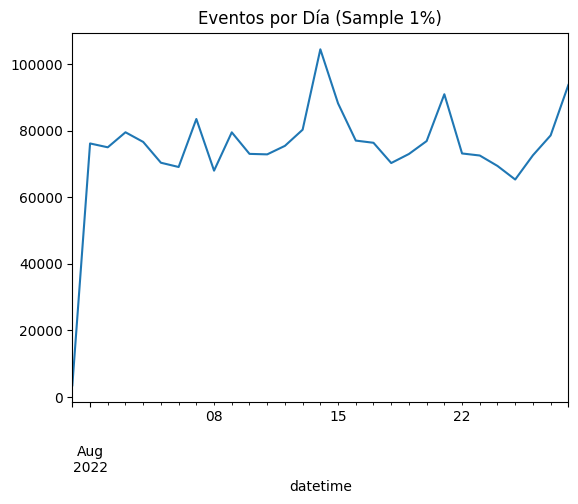

In [30]:
# Convertir timestamp a datetime (solo si es necesario)
train_df['datetime'] = pd.to_datetime(train_df['ts'], unit='ms')

# Eventos por día (muestra aleatoria del 1% para eficiencia)
train_df.sample(frac=0.01).set_index('datetime').resample('D')['type'].count().plot()
plt.title('Eventos por Día (Sample 1%)')
plt.show()

## Análisis de Sesiones
1. Duración Promedio de Sesiones

Procesando 216,384,937 filas en chunks de 10,000...


Procesando chunks: 100%|██████████| 21639/21639 [32:41<00:00, 11.03chunk/s]   



✔ Sesiones procesadas: 12,920,129 de 12,899,779 (100.2%)

📊 Estadísticas clave (segundos):
- Media: 591545.56
- Mediana: 185056.87
- 90% de sesiones ≤ 1825765.52s


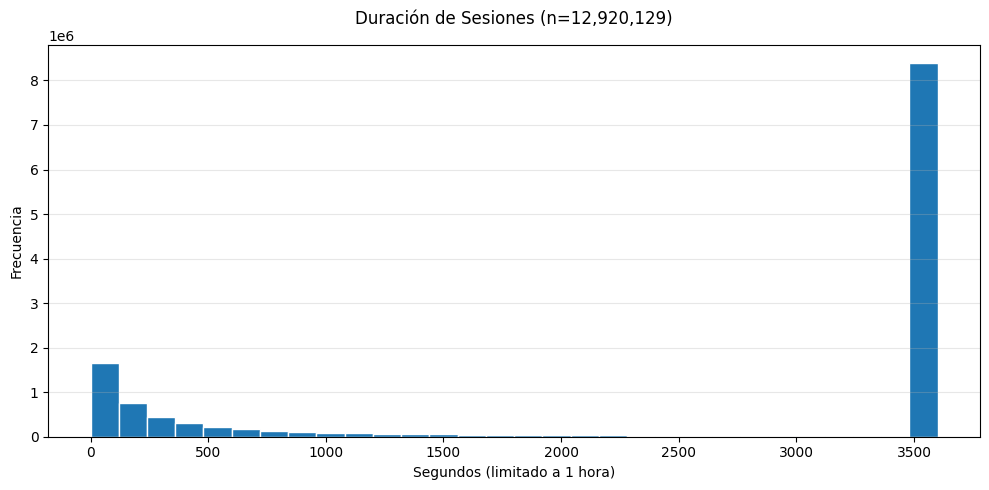


💾 Resultados guardados en 'session_durations.csv'


In [37]:

# =============================================
# 1. Configuración segura para grandes volúmenes
# =============================================
CHUNK_SIZE = 10_000  # Reducido para mayor seguridad
TOTAL_ROWS = len(train_df)
NUM_CHUNKS = (TOTAL_ROWS // CHUNK_SIZE) + 1



# =============================================
# 2. Procesamiento por chunks SIN MemoryError
# =============================================
def safe_chunk_processing(df, chunk_size):
    """Procesamiento seguro por chunks usando índices."""
    results = []
    for start in tqdm(range(0, len(df), chunk_size), 
                    desc="Procesando chunks",
                    unit="chunk"):
        end = min(start + chunk_size, len(df))
        chunk = df.iloc[start:end]
        duration = chunk.groupby('session')['datetime'].agg(
            lambda x: (x.max() - x.min()).total_seconds()
        )
        results.append(duration)
    return pd.concat(results)

print(f"Procesando {TOTAL_ROWS:,} filas en chunks de {CHUNK_SIZE:,}...")
session_duration = safe_chunk_processing(train_df, CHUNK_SIZE)

# =============================================
# 3. Verificación y análisis (igual que antes)
# =============================================
total_sessions = train_df['session'].nunique()
processed_sessions = len(session_duration)

print(f"\n✔ Sesiones procesadas: {processed_sessions:,} de {total_sessions:,} "
      f"({processed_sessions/total_sessions:.1%})")

# Estadísticas
stats = session_duration.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.95])
print("\n📊 Estadísticas clave (segundos):")
print(f"- Media: {stats['mean']:.2f}")
print(f"- Mediana: {stats['50%']:.2f}")
print(f"- 90% de sesiones ≤ {stats['90%']:.2f}s")

# =============================================
# 4. Visualización optimizada
# =============================================
plt.figure(figsize=(10, 5))
plt.hist(session_duration.clip(upper=3600), bins=30, 
         color='#1f77b4', edgecolor='white')
plt.title(f'Duración de Sesiones (n={processed_sessions:,})', pad=15)
plt.xlabel('Segundos (limitado a 1 hora)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



2. Eventos por Sesión


Media de eventos/sesión: 16.8


<Axes: title={'center': 'Distribución de Eventos por Sesión (hasta 20 eventos)'}, ylabel='Frequency'>

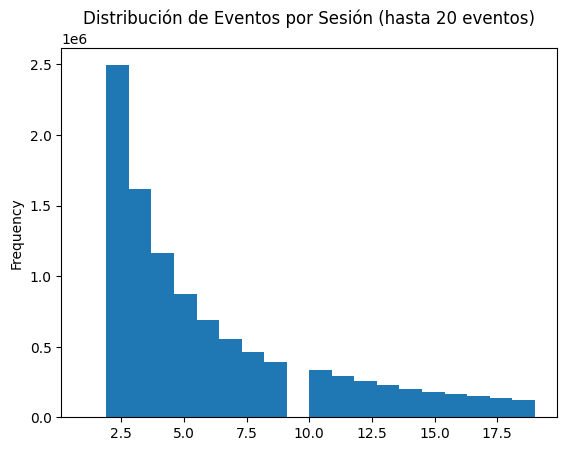

In [38]:
events_per_session = train_df.groupby('session').size()
print(f"\nMedia de eventos/sesión: {events_per_session.mean():.1f}")

events_per_session[events_per_session < 20].plot(  # Filtro para visualización
    kind='hist', 
    bins=20,
    title='Distribución de Eventos por Sesión (hasta 20 eventos)'
)

## Limpieza recomendada
1. Eliminar Sesiones Cortas

In [39]:
sessions_to_keep = events_per_session[events_per_session >= 3].index
train_df_clean = train_df[train_df['session'].isin(sessions_to_keep)]

In [41]:
train_df_clean.shape

(211394181, 6)

## Se guardan los dataframes para el modelo


In [7]:
train_df.to_csv('data/processed/train_df_clean.csv', index=False)
test_df.to_csv('data/processed/test_df_clean.csv', index=False)

In [8]:
train_df.head()

,session,aid,ts,type,source
0,0,1517085,1659304800025,clicks,train
1,0,1563459,1659304904511,clicks,train
2,0,1309446,1659367439426,clicks,train
3,0,16246,1659367719997,clicks,train
4,0,1781822,1659367871344,clicks,train
